In [2]:
import sys
sys.path.append('../')

In [3]:
from DPF import ShardsDatasetConfig, DatasetReader

config = ShardsDatasetConfig.from_path_and_columns(
    'example_dataset',
    image_name_col='image_name',
    text_col="caption"
)

reader = DatasetReader()
processor = reader.read_from_config(config)

  0%|          | 0/3 [00:00<?, ?it/s]

## Print metadata

In [4]:
processor.print_summary()

Dataset format: shards
Path: example_dataset
Modalities: ['image', 'text']
Columns: 3
Total samples: 500


In [5]:
processor.df

,image_path,text,split_name
0,example_dataset/0.tar/0.jpg,шотландцы в национальной одежде с флагом. - ba...,0
1,example_dataset/0.tar/1.jpg,королевская золотая корона с драгоценностями н...,0
2,example_dataset/0.tar/2.jpg,Пасха,0
3,example_dataset/0.tar/3.jpg,округа нью-джерси карта печати - elizabeth sto...,0
4,example_dataset/0.tar/4.jpg,"английская золотая корона с драгоценностями, и...",0
...,...,...,...
495,example_dataset/2.tar/495.jpg,bokeh Background,2
496,example_dataset/2.tar/496.jpg,"Healthcare, Medicine,",2
497,example_dataset/2.tar/497.jpg,A set of business teams icons that include edi...,2
498,example_dataset/2.tar/498.jpg,Vector floral pattern icon collection,2


## Removing duplicates

In [6]:
from DPF.filters.images.hash_filters import PHashFilter

datafilter = PHashFilter(sim_hash_size=8, workers=16)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)

['image_phash_8']


100%|██████████| 500/500 [00:01<00:00, 387.02it/s]


In [7]:
processor.filter_df(~processor.df['image_phash_8'].duplicated())
len(processor)

499

## Filter by aesthetic score

In [8]:
from DPF.filters.images.aesthetic_improved_filter import ImprovedAestheticFilter

datafilter = ImprovedAestheticFilter(
    weights_folder='../weights',  # path to weights folder, will be downloaded to this folder
    device='cuda:0',
    workers=16
)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)

['improved_aesthetic_score_ViT-L/14']


10it [00:05,  1.99it/s]                      


In [9]:
processor.df

,image_path,text,split_name,image_phash_8,improved_aesthetic_score_ViT-L/14
0,example_dataset/0.tar/0.jpg,шотландцы в национальной одежде с флагом. - ba...,0,e1f6e7c0e07f0e3d381f8fc07e09c7f0103fe07038ec7918,5.601146
1,example_dataset/0.tar/1.jpg,королевская золотая корона с драгоценностями н...,0,fc3100ffcd0b6301c8ef9f1c0399d8030ebfe38e047db03f,4.966230
2,example_dataset/0.tar/2.jpg,Пасха,0,effe38e3be07747080a1d9d8fe2fe80081f8ff8c2701f018,5.068741
3,example_dataset/0.tar/3.jpg,округа нью-джерси карта печати - elizabeth sto...,0,ec4007e06e0113b7f8f007e603f63f1381d81f8fff027e33,4.848436
4,example_dataset/0.tar/4.jpg,"английская золотая корона с драгоценностями, и...",0,e3f1c6ec703ffc01b81b9fc0216e0703efc2fc01b1fa81f0,5.539761
...,...,...,...,...,...
494,example_dataset/2.tar/495.jpg,bokeh Background,2,e431028fcd3581f1e6f073071df63df139c303b3d0f23417,5.285481
495,example_dataset/2.tar/496.jpg,"Healthcare, Medicine,",2,fb8efe188cc61869c6187c6618f9c019ec4618fc771c8ff8,4.501980
496,example_dataset/2.tar/497.jpg,A set of business teams icons that include edi...,2,fc70381c70381c71f81c71f81c70385fbe07e38fc7e38fc0,3.883074
497,example_dataset/2.tar/498.jpg,Vector floral pattern icon collection,2,e80f7f080d3c0fc13e0c4770f03ec5f38281f7e1bbe0b1c7,5.069400


In [12]:
processor.filter_df(processor.df['improved_aesthetic_score_ViT-L/14']>5.2)
len(processor)

207

## Check samples from filtered dataset

Gift boxes coming out of a yellow megaphone over yellow background. Horizontal composition with copy space. Great use for announcement concepts.


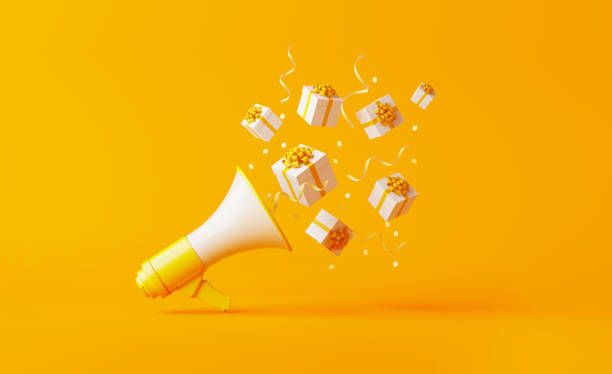

In [37]:
from PIL import Image
from io import BytesIO

m2d, metadata = processor.get_random_sample()
print(metadata['text'])
Image.open(BytesIO(m2d['image']))

## Sharding new dataset

In [38]:
processor.save_to_shards(
    'aesthetic_dataset_shards/',
    columns_to_save=['text', 'image_phash_8', 'improved_aesthetic_score_ViT-L/14'],
    rename_columns={'text': 'caption'},
    workers=16
)

100%|██████████| 207/207 [00:01<00:00, 205.79it/s]


## Reading new dataset

In [39]:
from DPF import ShardsDatasetConfig, DatasetReader

config = ShardsDatasetConfig.from_path_and_columns(
    'aesthetic_dataset_shards',
    image_name_col='image_name',
    text_col="caption"
)

reader = DatasetReader()
processor = reader.read_from_config(config)

  0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
processor.df

,image_path,text,split_name,improved_aesthetic_score_ViT-L/14,image_phash_8
0,aesthetic_dataset_shards/0.tar/0.jpg,шотландцы в национальной одежде с флагом. - ba...,0,5.601146,e1f6e7c0e07f0e3d381f8fc07e09c7f0103fe07038ec7918
1,aesthetic_dataset_shards/0.tar/1.jpg,фотореальный красный чемодан с городским фоном...,0,5.422980,ff8fc7e0713802703f0dcee7f031180bc7c76078189f84e7
2,aesthetic_dataset_shards/0.tar/2.jpg,Top view paper bag of different fresh health f...,0,5.558455,e3f0007ff600ec783ffc0fc0fc0bf9fc0dc87f8046807c07
3,aesthetic_dataset_shards/0.tar/3.jpg,"английская золотая корона с драгоценностями, и...",0,5.539761,e3f1c6ec703ffc01b81b9fc0216e0703efc2fc01b1fa81f0
4,aesthetic_dataset_shards/0.tar/4.jpg,Помолвка,0,5.234586,e00ec7077e381f803f63f1ff1f78381c033ce3ffc2e07004
...,...,...,...,...,...
202,aesthetic_dataset_shards/0.tar/202.jpg,"программисты, сотрудничающие в ит-компании, ра...",0,5.353548,e1f1fbe389ff0201df007fc01c0f00f3b800fc7e3f01ce67
203,aesthetic_dataset_shards/0.tar/203.jpg,Our new house - Latin family,0,5.283234,e081c0e3f7ffe1783ff21ffcff82017e0380fc403c1c3038
204,aesthetic_dataset_shards/0.tar/204.jpg,An urban downtown skyscraper shot at the corne...,0,5.727420,ff8fdcfbf020bc383f020e3af1bfc71c0d406302301c6fc6
205,aesthetic_dataset_shards/0.tar/205.jpg,Vector illustration of the infographic elements,0,5.409890,f08ffae137f4d0745aff4008ffc04bf04d83f23da01cc08b
